<a href="https://colab.research.google.com/github/J-a-y-a-shree/GRIP-TASK-1/blob/main/Final_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shape: (10573, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10573 entries, 0 to 10572
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Irradiance         10573 non-null  int64  
 1   AmbientTemp        10573 non-null  int64  
 2   rload              10573 non-null  float64
 3   cload              10573 non-null  float64
 4   fc                 10573 non-null  int64  
 5   f_samp             10573 non-null  int64  
 6   Inductor           10573 non-null  float64
 7   Capacitor          10573 non-null  float64
 8   Vpv_avg            10573 non-null  float64
 9   Ipv_avg            10573 non-null  float64
 10  DutyCycleActual    10573 non-null  float64
 11  Vout_avg           10573 non-null  float64
 12  Iout_avg           10573 non-null  float64
 13  P_out              10573 non-null  float64
 14  VoltageRipple_pp   10573 non-null  float64
 15  VoltageRipple_rms  10573 non-null  float64
 16  Cur

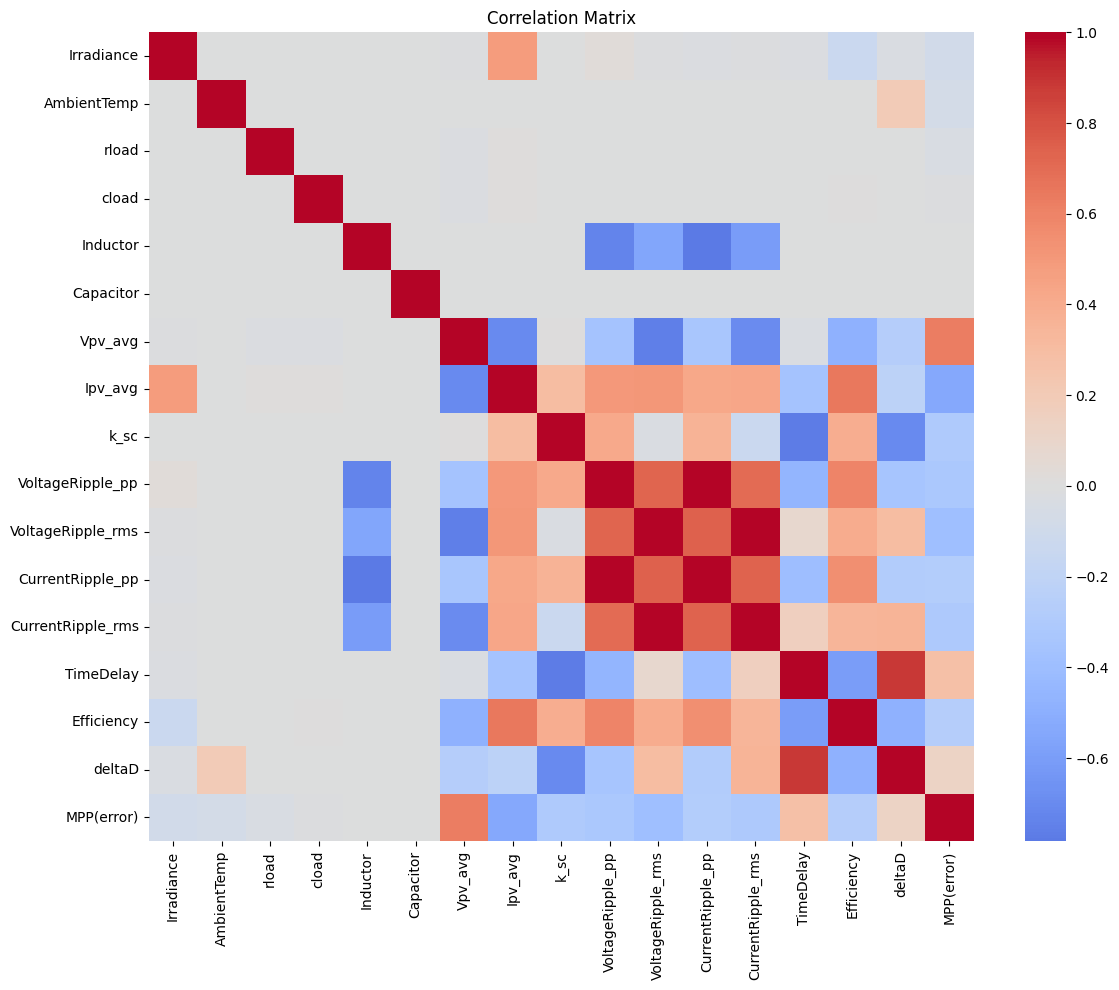

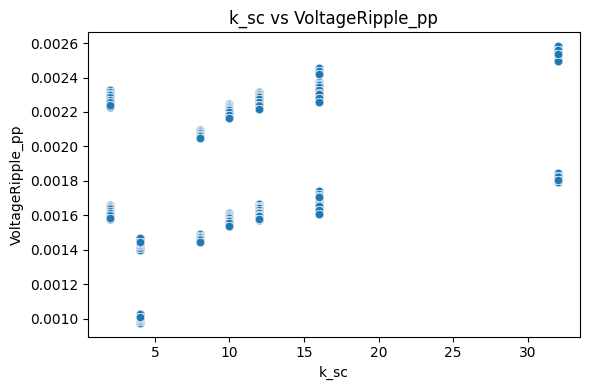

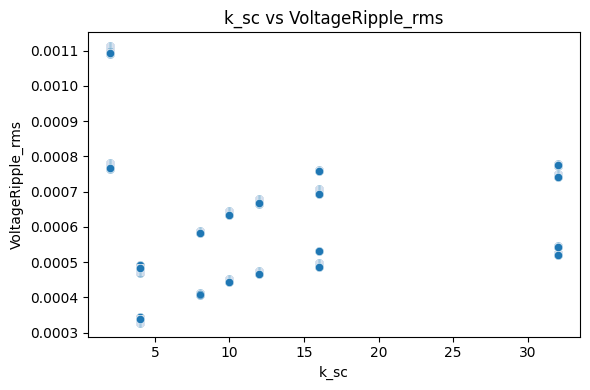

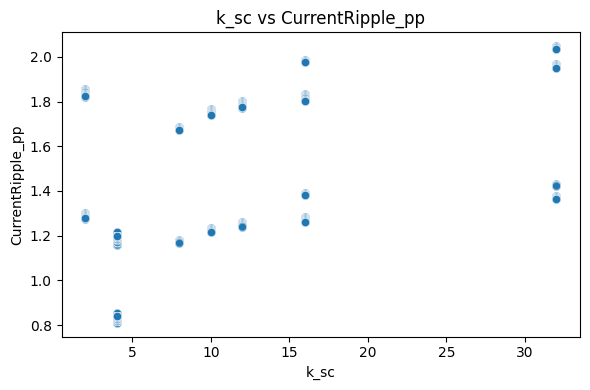

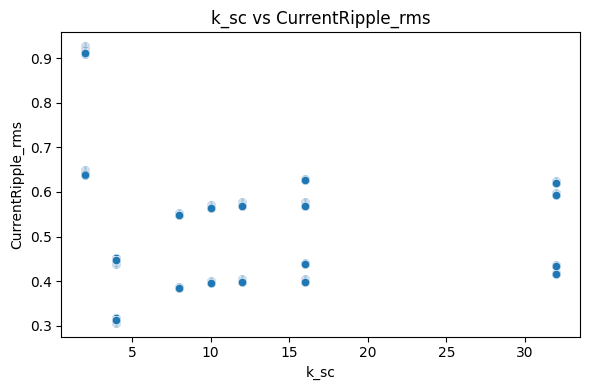

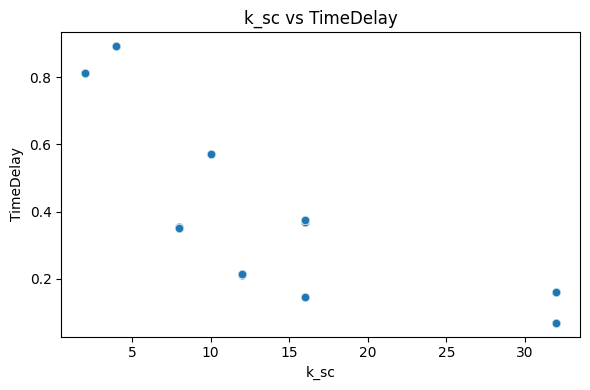

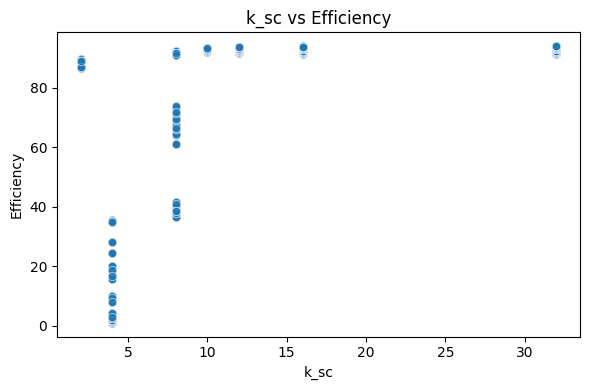

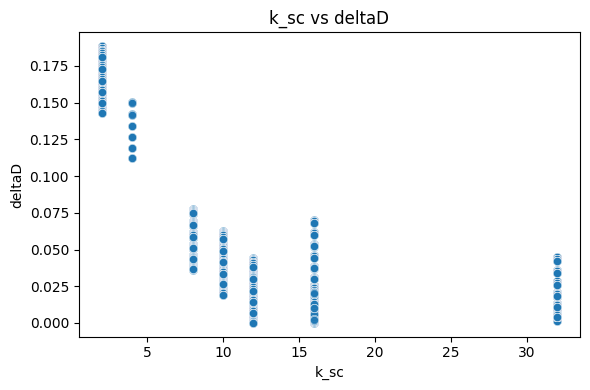

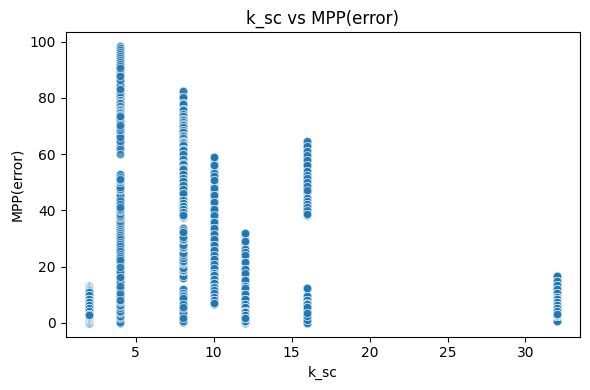

In [ ]:
# Phase 1 – EDA & Preprocessing

import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 1. Load & inspect
df = pd.read_csv("/content/Final_Dataset10kfinalAttempt.csv")
print("Shape:", df.shape)
print(df.info())
print(df.describe())
print("Missing values:\n", df.isna().sum())

# 2. Define inputs & targets
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor", "Capacitor", "Vpv_avg", "Ipv_avg", "k_sc"
]
target_cols = [
    "VoltageRipple_pp", "VoltageRipple_rms",
    "CurrentRipple_pp", "CurrentRipple_rms",
    "TimeDelay", "Efficiency", "deltaD", "MPP(error)"
]
X = df[input_cols].copy()
y = df[target_cols].copy()

# 3. Handle outliers on each target (clip to 1st–99th percentiles)
for col in target_cols:
    low, high = y[col].quantile([0.01, 0.99])
    y[col] = y[col].clip(low, high)

# 4. Group-split to train/val/test (by unique combinations of features excluding k_sc)
group_cols = ["Irradiance", "AmbientTemp", "rload", "cload", "Inductor", "Capacitor", "Vpv_avg", "Ipv_avg"]
df["group_key"] = df[group_cols].astype(str).agg("_".join, axis=1)

gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(gss.split(df, groups=df["group_key"]))

temp_df = df.iloc[temp_idx]
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(gss2.split(temp_df, groups=temp_df["group_key"]))

val_idx  = temp_df.index[val_idx_rel]
test_idx = temp_df.index[test_idx_rel]

X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_val,   y_val   = X.loc[val_idx],   y.loc[val_idx]
X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]

# 5. Scale features & targets
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train_scaled = scaler_X.transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

# save scalers for later inference
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

# 6. Check-point: EDA visualizations
# 6a. Correlation heatmap of all inputs + targets
plt.figure(figsize=(12,10))
sns.heatmap(df[input_cols + target_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# 6b. Scatterplots: k_sc vs each target
for col in target_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df["k_sc"], y=df[col], alpha=0.5)
    plt.xlabel("k_sc")
    plt.ylabel(col)
    plt.title(f"k_sc vs {col}")
    plt.tight_layout()
    plt.show()


In [ ]:

import tensorflow as tf

# Build a simple feed-forward network
inputs = tf.keras.Input(shape=(X_train_scaled.shape[1],))
x = tf.keras.layers.Dense(256, activation="relu")(inputs)
x = tf.keras.layers.Dense(256, activation="relu")(x)
outputs = tf.keras.layers.Dense(len(target_cols), activation="linear")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Early stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Train
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=64,
    callbacks=[es],
    verbose=2
)

# Save the model
model.save("surrogate_mlp_tf.keras")


Epoch 1/100
116/116 - 4s - 33ms/step - loss: 0.1868 - root_mean_squared_error: 0.4322 - val_loss: 0.0740 - val_root_mean_squared_error: 0.2720
Epoch 2/100
116/116 - 2s - 16ms/step - loss: 0.0558 - root_mean_squared_error: 0.2361 - val_loss: 0.0464 - val_root_mean_squared_error: 0.2153
Epoch 3/100
116/116 - 1s - 7ms/step - loss: 0.0346 - root_mean_squared_error: 0.1859 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1636
Epoch 4/100
116/116 - 1s - 11ms/step - loss: 0.0192 - root_mean_squared_error: 0.1385 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1207
Epoch 5/100
116/116 - 1s - 8ms/step - loss: 0.0096 - root_mean_squared_error: 0.0982 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0869
Epoch 6/100
116/116 - 0s - 4ms/step - loss: 0.0055 - root_mean_squared_error: 0.0745 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0692
Epoch 7/100
116/116 - 0s - 4ms/step - loss: 0.0037 - root_mean_squared_error: 0.0608 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
Epo

In [ ]:
# Phase 2 – Surrogate Performance in Percentage

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

# 1. Load your saved objects (adjust paths as needed)
# scaler_y   = joblib.load("scaler_y.pkl")
# model      = joblib.load("surrogate_model.pkl")  # or your Keras model
# X_test_scaled, y_test  # already in memory from Phase 1

# 2. Make predictions & inverse-transform
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = y_test.values  # shape (n_samples, n_targets)

# 3. Compute absolute errors
rmse_vals = np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))
mae_vals  = mean_absolute_error(y_true, y_pred, multioutput='raw_values')

# 4. Convert to percentage of the true-mean of each target
means = np.mean(y_true, axis=0)
rmse_pct = (rmse_vals / means) * 100
mae_pct  = (mae_vals  / means) * 100

# 5. Compute MAPE directly
mape_vals = [
    mean_absolute_percentage_error(y_true[:, i], y_pred[:, i]) * 100
    for i in range(y_true.shape[1])
]

# 6. Print percentage metrics
for name, rmse_p, mae_p, mape_p in zip(target_cols, rmse_pct, mae_pct, mape_vals):
    print(f"{name:20s}  RMSE% = {rmse_p:.2f}%   MAE% = {mae_p:.2f}%   MAPE = {mape_p:.2f}%")


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
VoltageRipple_pp      RMSE% = 0.25%   MAE% = 0.19%   MAPE = 0.21%
VoltageRipple_rms     RMSE% = 0.42%   MAE% = 0.35%   MAPE = 0.37%
CurrentRipple_pp      RMSE% = 0.25%   MAE% = 0.20%   MAPE = 0.21%
CurrentRipple_rms     RMSE% = 0.34%   MAE% = 0.28%   MAPE = 0.30%
TimeDelay             RMSE% = 1.21%   MAE% = 0.92%   MAPE = 1.35%
Efficiency            RMSE% = 0.95%   MAE% = 0.52%   MAPE = 3.50%
deltaD                RMSE% = 1.60%   MAE% = 1.23%   MAPE = 5.36%
MPP(error)            RMSE% = 3.07%   MAE% = 2.14%   MAPE = 12.75%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━

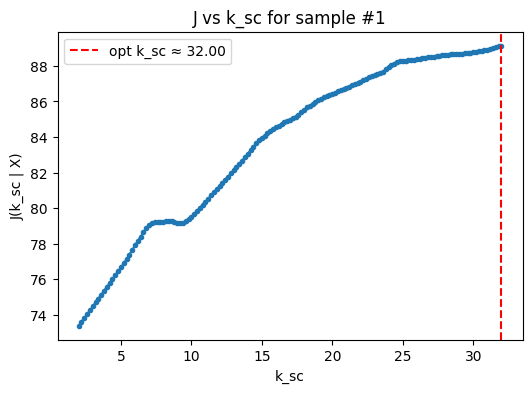

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

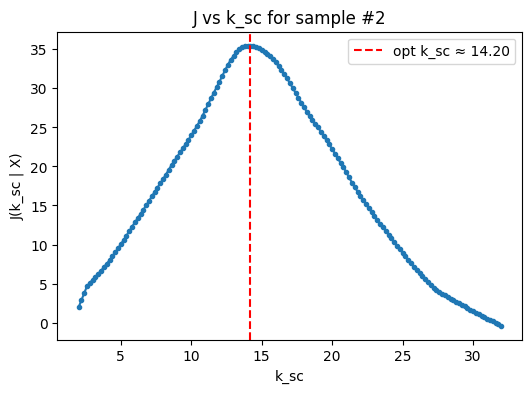

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

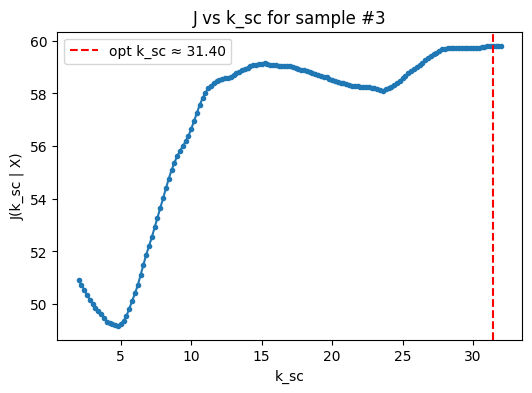

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from tensorflow import keras # Import keras to load the model

# ————————————————
# 1. Load models & scalers
# ————————————————
# Use keras.models.load_model to load the Keras model
surrogate = keras.models.load_model("surrogate_mlp_tf.keras")  # your MultiOutputRegressor
scaler_X   = joblib.load("scaler_X.pkl")        # feature StandardScaler
scaler_y   = joblib.load("scaler_y.pkl")        # target StandardScaler

# The 8 input columns (no k_sc) that your scaler_X expects:
input_cols_nok = [
    "Irradiance","AmbientTemp","rload","cload",
    "Inductor","Capacitor","Vpv_avg","Ipv_avg"
]

# ————————————————
# 2. Set weights
# ————————————————
alpha = 1.0
betas = np.ones(7)  # penalties for [Vpp, Vrms, Ipp, Irms, TimeDelay, deltaD, MPP(error)]

# ————————————————
# 3. Composite objective
# ————————————————
def J_of_ksc(X_raw, ksc_candidate):
    # X_raw: length-8 array matching input_cols_nok
    df_row = pd.DataFrame([ {**dict(zip(input_cols_nok, X_raw)),
                              "k_sc": ksc_candidate} ])
    # scale inputs
    Xs = scaler_X.transform(df_row)
    # predict all 8 targets
    y_hat_s = surrogate.predict(Xs)
    # inverse-scale back to original units
    y_hat   = scaler_y.inverse_transform(y_hat_s).ravel()
    # eta is 6th entry, penalties are the other seven (in order)
    eta       = y_hat[5]
    penalties = np.concatenate([
        y_hat[0:4],       # ripples
        [y_hat[4]],       # TimeDelay
        [y_hat[6]],       # deltaD
        [y_hat[7]]        # MPP(error)
    ])
    return eta - alpha * np.dot(betas, penalties)

# ————————————————
# 4. Sanity-check plots
# ————————————————
X_val_nok = X_val[input_cols_nok].values

for i, X_sample in enumerate(X_val_nok[:3]):
    k_grid = np.linspace(2, 32, 151)
    J_vals = [J_of_ksc(X_sample, k) for k in k_grid]

    plt.figure(figsize=(6,4))
    plt.plot(k_grid, J_vals, '-o', markersize=3)
    best_k = k_grid[np.argmax(J_vals)]
    plt.axvline(best_k, color='r', linestyle='--',
                label=f"opt k_sc ≈ {best_k:.2f}")
    plt.title(f"J vs k_sc for sample #{i+1}")
    plt.xlabel("k_sc")
    plt.ylabel("J(k_sc | X)")
    plt.legend()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import joblib
from tensorflow import keras # Import keras to load the model

# 1.1 Load your trained surrogate and scalers
# Use keras.models.load_model to load the Keras model
surrogate = keras.models.load_model("surrogate_mlp_tf.keras")
scaler_X   = joblib.load("scaler_X.pkl")        # feature StandardScaler
scaler_y   = joblib.load("scaler_y.pkl")        # target StandardScaler

# 1.2 Prepare your validation inputs (drop k_sc)
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg"
]
X_val_nok = X_val[input_cols].values   # assumes X_val DataFrame is in memory


In [ ]:
alpha = 1.0
betas = np.ones(7)  # one weight for each penalty term

def J_of_ksc(X_raw, ksc_candidate):
    # wrap into a DataFrame so scaler_X.transform() accepts it
    row = dict(zip(input_cols, X_raw))
    row["k_sc"] = ksc_candidate
    df_row = pd.DataFrame([row])

    # scale, predict, inverse-scale
    x_s = scaler_X.transform(df_row)
    y_s = surrogate.predict(x_s)
    y   = scaler_y.inverse_transform(y_s).ravel()
    # y = [Vpp, Vrms, Ipp, Irms, TimeDelay, Efficiency, deltaD, MPP(error)]

    eta      = y[5]
    penalties = np.r_[y[0:4], y[4], y[6], y[7]]
    return eta - alpha * (betas @ penalties)


In [ ]:
print(J_of_ksc(X_val_nok[0], 10.0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
79.51089796697488


In [ ]:
# candidate values from 2 to 32 (151 points)
k_grid = np.linspace(2, 32, 151)
print("k_grid:", k_grid[:5], "...", k_grid[-5:])


k_grid: [2.  2.2 2.4 2.6 2.8] ... [31.2 31.4 31.6 31.8 32. ]


In [ ]:
opt_k_small = []
for X_sample in X_val_nok[:10]:
    J_vals = [J_of_ksc(X_sample, k) for k in k_grid]
    opt_k_small.append(k_grid[np.argmax(J_vals)])

print("First 10 optimal k_sc:", opt_k_small)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━

In [22]:
import numpy as np
import pandas as pd
import joblib
from joblib import Parallel, delayed
from tensorflow import keras # Import keras to load the model

# ————————————————
# 1. Load full dataset
# ————————————————
df_full = pd.read_csv("/content/Final_Dataset10kfinalAttempt.csv")

# 2. Define your 8 inputs (no k_sc)
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg"
]
X_full = df_full[input_cols].values   # shape (10573, 8)

# ————————————————
# 3. Load surrogate & scalers
# ————————————————
# Use keras.models.load_model to load the Keras model
surrogate = keras.models.load_model("surrogate_mlp_tf.keras")  # your trained MultiOutputRegressor
scaler_X   = joblib.load("scaler_X.pkl")        # feature StandardScaler
scaler_y   = joblib.load("scaler_y.pkl")        # target StandardScaler

# ————————————————
# 4. Prepare integer-only k_sc grid
# ————————————————
k_grid = np.arange(2, 33, 1)  # integers 2,3,...,32

# ————————————————
# 5. Define your composite objective J
# ————————————————
alpha = 1.0
betas = np.ones(7)  # weights for [Vpp, Vrms, Ipp, Irms, TimeDelay, deltaD, MPP(error)]

def find_opt_k_vectorized(X_raw):
    """
    Vectorized search: for one 8-dim input X_raw, evaluate J over all k in k_grid
    and return the integer k_sc that maximizes J.
    """
    # build a DataFrame of shape (n_k, 9) with columns input_cols + ["k_sc"]
    df_rows = pd.DataFrame([
        {**dict(zip(input_cols, X_raw)), "k_sc": k}
        for k in k_grid
    ])
    # batch transform & predict
    Xs = scaler_X.transform(df_rows)
    Ys = surrogate.predict(Xs)                   # shape (n_k, 8)
    Ys_orig = scaler_y.inverse_transform(Ys)      # back to real-unit metrics

    # compute penalties and objectives
    ripples      = Ys_orig[:, 0:4].sum(axis=1)    # sum of the 4 ripple metrics
    time_delay   = Ys_orig[:, 4]
    efficiency   = Ys_orig[:, 5]
    delta_d      = Ys_orig[:, 6]
    mpp_error    = Ys_orig[:, 7]
    penalties    = ripples + time_delay + delta_d + mpp_error
    objectives   = efficiency - alpha * penalties

    # pick the k_sc with max objective
    best_idx = np.argmax(objectives)
    return int(k_grid[best_idx])

# ————————————————
# 6. Run over the full dataset in parallel
# ————————————————
# This will use all available CPU cores (set n_jobs to your preferred value)
opt_k_full = Parallel(n_jobs=-1, verbose=5)(
    delayed(find_opt_k_vectorized)(X_full[i])
    for i in range(len(X_full))
)

# ————————————————
# 7. Assemble & save the results
# ————————————————
out_df = df_full[input_cols].copy()
out_df["k_sc_opt"] = opt_k_full
out_df.to_csv("k_sc_opt_full_dataset.csv", index=False)

print(f"Saved {len(out_df)} optimal k_sc values to 'k_sc_opt_full_dataset.csv'")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2174 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed:  8.6min
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be ca

Saved 10573 optimal k_sc values to 'k_sc_opt_full_dataset.csv'


[Parallel(n_jobs=-1)]: Done 10573 out of 10573 | elapsed: 34.4min finished


In [23]:
# Phase 5a – Baseline Random Forest for direct k_sc prediction (percentage metrics)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

# 1. Load your full mapping of features → optimal k_sc
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Split into train / validation sets (85% train, 15% val)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Train a baseline Random Forest
rf_base = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_base.fit(X_train, y_train)
joblib.dump(rf_base, "direct_rf_baseline.pkl")

# 4. Predict on validation set
y_pred = rf_base.predict(X_val)

# 5. Compute percentage-based metrics
# RMSE% and MAE% relative to mean of true k_sc values
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae  = mean_absolute_error(y_val, y_pred)
mean_k = np.mean(y_val)
rmse_pct = (rmse / mean_k) * 100
mae_pct  = (mae  / mean_k) * 100

# MAPE is already a percentage metric
mape_pct = mean_absolute_percentage_error(y_val, y_pred) * 100

# Percentage of predictions within ±1 k_sc unit
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100

# 6. Display results
print("RF baseline performance on validation (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")


RF baseline performance on validation (percentages):
  RMSE%       = 19.95%
  MAE%        = 9.17%
  MAPE%       = 11.89%
  % within ±1 = 68.6%


In [24]:
# Phase 5b – Hyperparameter‐Tuned Random Forest

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

# 1. Load data
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = ["Irradiance","AmbientTemp","rload","cload","Inductor","Capacitor","Vpv_avg","Ipv_avg"]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. GridSearch over RF hyperparameters
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth":    [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}
grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_train, y_train)

# 4. Save best model
rf_tuned = grid_rf.best_estimator_
joblib.dump(rf_tuned, "direct_rf_tuned.pkl")
print("Best RF params:", grid_rf.best_params_)

# 5. Evaluate on validation set (percentage metrics)
y_pred = rf_tuned.predict(X_val)
mean_k   = np.mean(y_val)
rmse_pct = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct  = mean_absolute_error      (y_val, y_pred) / mean_k * 100
mape_pct = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100

print("\nTuned RF performance:")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")


Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}

Tuned RF performance:
  RMSE%       = 19.91%
  MAE%        = 9.12%
  MAPE%       = 11.91%
  % within ±1 = 69.1%


In [25]:
rmse_frac = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k
print(f"RMSE fraction = {rmse_frac:.3f}")  # e.g. 0.199


RMSE fraction = 0.199


In [26]:
# Phase 5c – Baseline XGBoost for direct k_sc prediction (percentage metrics)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb
import joblib

# 1. Load your full mapping of features → optimal k_sc
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Split into train / validation sets (85% train, 15% val)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Train a baseline XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

# 4. Save the model
joblib.dump(xgb_model, "direct_xgb_baseline.pkl")

# 5. Predict on validation set
y_pred = xgb_model.predict(X_val)

# 6. Compute percentage‐based metrics
mean_k    = np.mean(y_val)
rmse_pct  = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct   = mean_absolute_error       (y_val, y_pred) / mean_k * 100
mape_pct  = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100

# 7. Display results
print("XGBoost baseline performance on validation (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")


XGBoost baseline performance on validation (percentages):
  RMSE%       = 22.91%
  MAE%        = 13.69%
  MAPE%       = 18.25%
  % within ±1 = 47.2%


In [27]:
# Phase 5d – Hyperparameter-Tuned XGBoost for direct k_sc prediction

import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb

# 1. Load the full mapping of features → optimal k_sc
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Split into train / validation sets (85% train, 15% val)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Set up GridSearch over XGBoost hyperparameters
param_grid = {
    "n_estimators":    [100, 300, 500],
    "max_depth":       [3, 6, 10],
    "learning_rate":   [0.01, 0.1, 0.2],
    "subsample":       [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1, objective="reg:squarederror")

grid_xgb = GridSearchCV(
    xgb_model,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

# 4. Run the search
grid_xgb.fit(X_train, y_train)

# 5. Save the best model
xgb_tuned = grid_xgb.best_estimator_
joblib.dump(xgb_tuned, "direct_xgb_tuned.pkl")
print("Best XGB params:", grid_xgb.best_params_)

# 6. Evaluate on validation set (percentage metrics)
y_pred = xgb_tuned.predict(X_val)
mean_k   = np.mean(y_val)

rmse_pct  = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct   = mean_absolute_error      (y_val, y_pred) / mean_k * 100
mape_pct  = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100

print("\nTuned XGBoost performance on validation (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best XGB params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.8}

Tuned XGBoost performance on validation (percentages):
  RMSE%       = 20.29%
  MAE%        = 10.29%
  MAPE%       = 13.06%
  % within ±1 = 62.5%


In [28]:
# Phase 5e – Baseline LightGBM for direct k_sc prediction (percentage metrics)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from lightgbm import LGBMRegressor
import joblib

# 1. Load your full mapping of features → optimal k_sc
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Split into train / validation sets (85% train, 15% val)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Train a baseline LightGBM regressor
lgb_model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)
lgb_model.fit(X_train, y_train)

# 4. Save the model
joblib.dump(lgb_model, "direct_lgb_baseline.pkl")

# 5. Predict on validation set
y_pred = lgb_model.predict(X_val)

# 6. Compute percentage‐based metrics
mean_k     = np.mean(y_val)
rmse_pct   = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct    = mean_absolute_error       (y_val, y_pred) / mean_k * 100
mape_pct   = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100

# 7. Display results
print("LightGBM baseline performance on validation (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 8987, number of used features: 8
[LightGBM] [Info] Start training from score 18.752977
LightGBM baseline performance on validation (percentages):
  RMSE%       = 22.89%
  MAE%        = 13.76%
  MAPE%       = 18.33%
  % within ±1 = 45.6%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [30]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
import joblib

# 1. Reload data & split (as before)
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = ["Irradiance","AmbientTemp","rload","cload",
              "Inductor","Capacitor","Vpv_avg","Ipv_avg"]
X = df[input_cols].values
y = df["k_sc_opt"].values
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 2. Define a smaller hyper-parameter space
param_dist = {
    "n_estimators":    [100, 300, 500],
    "max_depth":       [-1, 10, 20],
    "learning_rate":   [0.01, 0.05, 0.1],
    "num_leaves":      [31, 63, 127]
}

lgb = LGBMRegressor(random_state=42, n_jobs=-1)
rand_lgb = RandomizedSearchCV(
    lgb,
    param_distributions=param_dist,
    n_iter=20,                # only try 20 random combos
    cv=3,                     # 3-fold CV instead of 5
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rand_lgb.fit(X_train, y_train)
lgb_tuned = rand_lgb.best_estimator_
joblib.dump(lgb_tuned, "direct_lgb_randsearch.pkl")
print("Best rand-LGB params:", rand_lgb.best_params_)

# 3. Quick validation
y_pred = lgb_tuned.predict(X_val)
mean_k   = np.mean(y_val)
rmse_pct = (np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k) * 100
mae_pct  = (mean_absolute_error(y_val, y_pred) / mean_k) * 100
mape_pct = mean_absolute_percentage_error(y_val, y_pred) * 100
pct1     = np.mean(np.abs(y_pred - y_val) <= 1) * 100

print(f"Rand-LGB performance: RMSE%={rmse_pct:.2f}%  MAE%={mae_pct:.2f}%  "
      f"MAPE={mape_pct:.2f}%  %±1={pct1:.1f}%")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 8987, number of used features: 8
[LightGBM] [Info] Start training from score 18.752977
Best rand-LGB params: {'num_leaves': 127, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.05}
Rand-LGB performance: RMSE%=20.58%  MAE%=10.97%  MAPE=14.57%  %±1=58.7%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [33]:
# Phase 5h – Upgraded Keras MLP for direct k_sc prediction

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
)

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Load data
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Scale inputs
scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)

# 4. Build a deeper MLP with BatchNorm & Dropout
inp = Input(shape=(X_train_scaled.shape[1],))
x = Dense(256, activation="relu")(inp)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

out = Dense(1, activation="linear")(x)

model = Model(inputs=inp, outputs=out)
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# 5. Callbacks for early stopping and LR reduction
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)

# 6. Train
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[es, rlr],
    verbose=2
)

# 7. Evaluate on validation set (percentage metrics)
y_pred = model.predict(X_val_scaled).ravel()
mean_k   = np.mean(y_val)

rmse_pct   = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct    = mean_absolute_error       (y_val, y_pred) / mean_k * 100
mape_pct   = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1= np.mean(np.abs(y_pred - y_val) <= 1) * 100

print("Upgraded MLP performance on validation (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")

# 8. Save model & scaler
model.save("direct_mlp_upgraded.h5")
import joblib; joblib.dump(scaler_X, "scaler_X_direct_mlp.pkl")


Epoch 1/100
141/141 - 6s - 42ms/step - loss: 381.4050 - root_mean_squared_error: 19.5296 - val_loss: 361.4119 - val_root_mean_squared_error: 19.0108 - learning_rate: 1.0000e-03
Epoch 2/100
141/141 - 1s - 8ms/step - loss: 242.3178 - root_mean_squared_error: 15.5666 - val_loss: 156.5938 - val_root_mean_squared_error: 12.5137 - learning_rate: 1.0000e-03
Epoch 3/100
141/141 - 2s - 13ms/step - loss: 98.2223 - root_mean_squared_error: 9.9107 - val_loss: 48.3407 - val_root_mean_squared_error: 6.9528 - learning_rate: 1.0000e-03
Epoch 4/100
141/141 - 2s - 13ms/step - loss: 50.0195 - root_mean_squared_error: 7.0724 - val_loss: 30.8568 - val_root_mean_squared_error: 5.5549 - learning_rate: 1.0000e-03
Epoch 5/100
141/141 - 1s - 7ms/step - loss: 42.6244 - root_mean_squared_error: 6.5287 - val_loss: 27.1057 - val_root_mean_squared_error: 5.2063 - learning_rate: 1.0000e-03
Epoch 6/100
141/141 - 1s - 9ms/step - loss: 39.9188 - root_mean_squared_error: 6.3181 - val_loss: 25.4351 - val_root_mean_squared

Upgraded MLP performance on validation (percentages):
  RMSE%       = 20.43%
  MAE%        = 11.24%
  MAPE%       = 14.96%
  % within ±1 = 55.5%


['scaler_X_direct_mlp.pkl']

In [37]:
# Phase 5h(3) – Hyperparameter Tuning of the Residual MLP with Keras Tuner
!pip install keras-tuner -q
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
)

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Add, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt

# 1. Load & split
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = ["Irradiance","AmbientTemp","rload","cload","Inductor","Capacitor","Vpv_avg","Ipv_avg"]
X = df[input_cols].values
y = df["k_sc_opt"].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# 2. Scale inputs
scaler_X = StandardScaler().fit(X_train)
X_train_s = scaler_X.transform(X_train)
X_val_s   = scaler_X.transform(X_val)

# 3. Build tuner model function
def build_residual_mlp(hp):
    inp = Input(shape=(X_train_s.shape[1],))
    x = inp
    # first dense block
    x = Dense(
        units=hp.Int("first_units", 128, 512, step=64),
        kernel_regularizer=l2(hp.Float("l2_reg", 1e-5, 1e-3, sampling="log"))
    )(x)
    x = BatchNormalization()(x)
    x = Activation(hp.Choice("first_act", ["relu", "swish"]))(x)
    x = Dropout(hp.Float("first_drop", 0.2, 0.5, step=0.1))(x)

    # variable number of residual blocks
    for i in range(hp.Int("n_res_blocks", 1, 3)):
        res = Dense(
            units=hp.Int(f"res_units_{i}", 128, 512, step=64),
            kernel_regularizer=l2(hp.Float(f"l2_reg_{i}", 1e-5, 1e-3, sampling="log"))
        )(x)
        res = BatchNormalization()(res)
        res = Activation(hp.Choice(f"res_act_{i}", ["relu", "swish"]))(res)
        res = Dropout(hp.Float(f"res_drop_{i}", 0.2, 0.5, step=0.1))(res)
        res = Dense(
            units=x.shape[-1],
            kernel_regularizer=l2(hp.Float(f"l2_reg2_{i}", 1e-5, 1e-3, sampling="log"))
        )(res)
        res = BatchNormalization()(res)
        x = Add()([x, res])
        x = Activation(hp.Choice(f"res_out_act_{i}", ["relu", "swish"]))(x)

    # output block
    x = Dense(
        units=hp.Int("final_units", 64, 256, step=64),
        activation=hp.Choice("final_act", ["relu", "swish"]),
        kernel_regularizer=l2(hp.Float("l2_reg_final", 1e-5, 1e-3, sampling="log"))
    )(x)
    x = Dropout(hp.Float("final_drop", 0.1, 0.3, step=0.1))(x)
    out = Dense(1, activation="linear")(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=Adam(hp.Float("lr", 1e-4, 1e-2, sampling="log")),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

# 4. Set up Hyperband tuner
tuner = kt.Hyperband(
    build_residual_mlp,
    objective="val_root_mean_squared_error",
    max_epochs=50,
    factor=3,
    directory="res_mlp_tuner",
    project_name="direct_residual_mlp"
)

# 5. Early stopping callback
stop_early = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# 6. Run tuner search
tuner.search(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    callbacks=[stop_early],
    verbose=1
)

# 7. Retrieve best model and evaluate
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)
best_model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=50,
    callbacks=[stop_early],
    verbose=1
)

# 8. Evaluate on validation set
y_pred = best_model.predict(X_val_s).ravel()
mean_k   = np.mean(y_val)
rmse_pct   = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct    = mean_absolute_error       (y_val, y_pred) / mean_k * 100
mape_pct   = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1= np.mean(np.abs(y_pred - y_val) <= 1) * 100

print("Tuned Residual MLP performance (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")

# 9. Save best model & scaler
best_model.save("direct_res_mlp_tuned.h5")
import joblib; joblib.dump(scaler_X, "scaler_X_direct_res_mlp_tuned.pkl")


Trial 90 Complete [00h 02m 06s]
val_root_mean_squared_error: 5.045710563659668

Best val_root_mean_squared_error So Far: 4.217179298400879
Total elapsed time: 01h 35m 32s
Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 84.5865 - root_mean_squared_error: 9.0565 - val_loss: 47.5639 - val_root_mean_squared_error: 6.8896
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 50.3550 - root_mean_squared_error: 7.0882 - val_loss: 43.6274 - val_root_mean_squared_error: 6.5971
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 47.7528 - root_mean_squared_error: 6.9016 - val_loss: 36.6146 - val_root_mean_squared_error: 6.0414
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 46.8482 - root_mean_squared_error: 6.8318 - val_loss: 36.5013 - val_root_mean_squared_error: 6.0313
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 43.1274 - root_mean_squared_error: 6.5549 - val_loss: 31.3930 - val_root_mean_squared_error: 5.5908
Epoch 6/50
281/281 ━━━━━

Tuned Residual MLP performance (percentages):
  RMSE%       = 22.76%
  MAE%        = 15.00%
  MAPE%       = 19.53%
  % within ±1 = 29.7%


['scaler_X_direct_res_mlp_tuned.pkl']

In [41]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
)

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt
import joblib

# 1. Load & split data
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = ["Irradiance","AmbientTemp","rload","cload",
              "Inductor","Capacitor","Vpv_avg","Ipv_avg"]
X = df[input_cols].values
y = df["k_sc_opt"].values
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 2. Scale inputs
scaler_X = StandardScaler().fit(X_train)
X_train_s = scaler_X.transform(X_train)
X_val_s   = scaler_X.transform(X_val)

# 3. Define tunable MLP builder
def build_small_mlp(hp):
    inp = Input(shape=(X_train_s.shape[1],))
    x = inp
    # only 1–2 dense layers, 64–256 units
    for i in range(hp.Int("layers", 1, 2)):
        x = Dense(
            units=hp.Int(f"units_{i}", 64, 256, step=64),
            activation="swish"
        )(x)
        x = Dropout(hp.Float(f"drop_{i}", 0.1, 0.3, step=0.1))(x)
    out = Dense(1, activation="linear")(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=Adam(hp.Float("lr", 1e-4, 1e-3, sampling="log")),
        loss="mse",
        metrics=["root_mean_squared_error"]
    )
    return model

# 4. Set up Hyperband tuner optimizing validation loss
tuner = kt.Hyperband(
    build_small_mlp,
    objective="val_loss",
    max_epochs=20,
    factor=2,
    directory="fast_mlp_tuner",
    project_name="direct_mlp_fast"
)

stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# 5. Run tuner search
tuner.search(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    callbacks=[stop],
    verbose=1
)

# 6. Retrieve best model and fine-tune
best_model = tuner.get_best_models(num_models=1)[0]
best_model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=20,
    callbacks=[stop],
    verbose=1
)

# 7. Evaluate performance on validation set
y_pred = best_model.predict(X_val_s).ravel()
mean_k = np.mean(y_val)

rmse_pct    = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct     = mean_absolute_error       (y_val, y_pred) / mean_k * 100
mape_pct    = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100

print("Fast MLP Tuned performance (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")

# 8. Save best model & scaler
best_model.save("direct_mlp_fast_tuned.h5")
joblib.dump(scaler_X, "scaler_X_direct_mlp_fast.pkl")


Trial 84 Complete [00h 00m 36s]
val_loss: 57.45674133300781

Best val_loss So Far: 32.87364959716797
Total elapsed time: 00h 28m 03s
Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 33.7346 - root_mean_squared_error: 5.8073 - val_loss: 33.4380 - val_root_mean_squared_error: 5.7826
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 34.1046 - root_mean_squared_error: 5.8390 - val_loss: 31.8688 - val_root_mean_squared_error: 5.6452
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 32.6386 - root_mean_squared_error: 5.7124 - val_loss: 31.7870 - val_root_mean_squared_error: 5.6380
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 33.9094 - root_mean_squared_error: 5.8227 - val_loss: 31.8673 - val_root_mean_squared_error: 5.6451
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 32.8993 - root_mean_squared_error: 5.7353 - val_loss: 31.1573 - val_root_mean_squared_error: 5.5819
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 31.4990

Fast MLP Tuned performance (percentages):
  RMSE%       = 28.11%
  MAE%        = 19.60%
  MAPE%       = 33.00%
  % within ±1 = 28.2%


['scaler_X_direct_mlp_fast.pkl']

In [42]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import joblib

# assume X_train, X_val, y_train, y_val are in memory (unscaled is OK here)

param_dist = {
    "hidden_layer_sizes": [(64,), (128,), (64,64), (128,64)],
    "alpha": [1e-4, 1e-3, 1e-2],
    "learning_rate_init": [1e-4, 1e-3],
}

mlp = MLPRegressor(
    solver="adam",
    max_iter=200,
    random_state=42
)

rand_mlp = RandomizedSearchCV(
    mlp,
    param_distributions=param_dist,
    n_iter=10,             # only 10 random combos
    cv=3,
    scoring=make_scorer(lambda y, yhat: np.sqrt(mean_squared_error(y, yhat)), greater_is_better=False),
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rand_mlp.fit(X_train, y_train)
joblib.dump(rand_mlp.best_estimator_, "direct_mlp_sklearn_tuned.pkl")

# Quick validation
y_pred = rand_mlp.predict(X_val)
mean_k = np.mean(y_val)
rmse_pct = (np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k) * 100
mae_pct  = (np.mean(np.abs(y_val - y_pred)) / mean_k) * 100
mape_pct = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
pct_within1 = np.mean(np.abs(y_val - y_pred) <= 1) * 100

print(f"Sklearn-MLP Tuned → RMSE%={rmse_pct:.2f}%  MAE%={mae_pct:.2f}%  "
      f"MAPE={mape_pct:.2f}%  %±1={pct_within1:.1f}%")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Sklearn-MLP Tuned → RMSE%=42.50%  MAE%=33.23%  MAPE=61.34%  %±1=10.3%


In [43]:
# Phase 5i – Baseline K-Nearest Neighbors for direct k_sc prediction (percentage metrics)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

# 1. Load your full mapping of features → optimal k_sc
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Split into train / validation sets (85% train, 15% val)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Train a baseline KNN regressor
knn = KNeighborsRegressor(
    n_neighbors=5,
    weights="uniform",
    algorithm="auto",
    n_jobs=-1
)
knn.fit(X_train, y_train)

# 4. Save the model
joblib.dump(knn, "direct_knn_baseline.pkl")

# 5. Predict on validation set
y_pred = knn.predict(X_val)

# 6. Compute percentage‐based metrics
mean_k     = np.mean(y_val)
rmse_pct   = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct    = mean_absolute_error       (y_val, y_pred) / mean_k * 100
mape_pct   = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100

# 7. Display results
print("KNN baseline performance on validation (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")


KNN baseline performance on validation (percentages):
  RMSE%       = 29.91%
  MAE%        = 17.76%
  MAPE%       = 22.21%
  % within ±1 = 45.9%


In [44]:
# Phase 5j – Hyperparameter‐Tuned KNN for direct k_sc prediction

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

# 1. Load mapping of features → optimal k_sc
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Split into train / validation (85% / 15%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Set up GridSearch over KNN hyperparameters
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "p": [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

knn = KNeighborsRegressor(algorithm="auto", n_jobs=-1)
grid_knn = GridSearchCV(
    knn,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

# 4. Run the search
grid_knn.fit(X_train, y_train)

# 5. Retrieve & save best model
knn_tuned = grid_knn.best_estimator_
joblib.dump(knn_tuned, "direct_knn_tuned.pkl")
print("Best KNN params:", grid_knn.best_params_)

# 6. Evaluate on validation set (percentage metrics)
y_pred = knn_tuned.predict(X_val)
mean_k    = np.mean(y_val)
rmse_pct  = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct   = mean_absolute_error       (y_val, y_pred) / mean_k * 100
mape_pct  = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100

print("\nTuned KNN performance on validation (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best KNN params: {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}

Tuned KNN performance on validation (percentages):
  RMSE%       = 29.35%
  MAE%        = 17.90%
  MAPE%       = 22.87%
  % within ±1 = 43.7%


In [45]:
# Phase 5k – Baseline Support-Vector Regression for direct k_sc prediction (percentage metrics)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

# 1. Load your full mapping of features → optimal k_sc
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Split into train / validation sets (85% train, 15% val)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Scale features (SVR is sensitive to feature scale)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)

# 4. Train a baseline SVR with RBF kernel
svr = SVR(
    kernel="rbf",
    C=10.0,
    gamma="scale",
    epsilon=0.1
)
svr.fit(X_train_s, y_train)

# 5. Save the model and scaler
joblib.dump(svr, "direct_svr_baseline.pkl")
joblib.dump(scaler, "scaler_SVR.pkl")

# 6. Predict on validation set
y_pred = svr.predict(X_val_s)

# 7. Compute percentage-based metrics
mean_k     = np.mean(y_val)
rmse_pct   = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct    = mean_absolute_error       (y_val, y_pred) / mean_k * 100
mape_pct   = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100

# 8. Display results
print("SVR baseline performance on validation (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")


SVR baseline performance on validation (percentages):
  RMSE%       = 34.64%
  MAE%        = 23.12%
  MAPE%       = 44.00%
  % within ±1 = 32.5%


In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

# 1. Load the full mapping of features → optimal k_sc
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Split into train / validation sets (85% train, 15% val)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Build a pipeline: scale inputs then SVR
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR())
])

# 4. Define a randomized search over key hyperparameters
param_dist = {
    "svr__kernel": ["rbf", "poly"],
    "svr__C": [0.1, 1, 10, 100],
    "svr__gamma": ["scale", "auto"],
    "svr__epsilon": [0.01, 0.1, 0.5, 1.0],
    "svr__degree": [2, 3]  # only used if kernel="poly"
}

rand_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=30,               # try 30 random combinations
    cv=3,                    # 3-fold CV for speed
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 5. Run the search
rand_search.fit(X_train, y_train)
best_model = rand_search.best_estimator_
print("Best SVR params:", rand_search.best_params_)

# 6. Save the tuned model
joblib.dump(best_model, "direct_svr_tuned.pkl")

# 7. Predict on validation set
y_pred = best_model.predict(X_val)

# 8. Compute percentage-based metrics
mean_k     = np.mean(y_val)
rmse_pct   = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct    = mean_absolute_error       (y_val, y_pred) / mean_k * 100
mape_pct   = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100

# 9. Display results in a table
metrics = pd.DataFrame({
    "Metric": ["RMSE%", "MAE%", "MAPE%", "% within ±1"],
    "Value": [
        f"{rmse_pct:.2f}%",
        f"{mae_pct:.2f}%",
        f"{mape_pct:.2f}%",
        f"{pct_within1:.1f}%"
    ]
})

print("\nSVR Tuned Performance on Validation:")
print(metrics.to_string(index=False))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best SVR params: {'svr__kernel': 'rbf', 'svr__gamma': 'scale', 'svr__epsilon': 0.5, 'svr__degree': 2, 'svr__C': 100}

SVR Tuned Performance on Validation:
     Metric  Value
      RMSE% 31.71%
       MAE% 20.86%
      MAPE% 35.19%
% within ±1  34.1%
